In [1]:
!nvidia-smi

Fri Mar  3 10:27:35 KST 2023

+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 455.32.00    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:14:00.0 Off |                    0 |
| N/A   32C    P0    24W / 250W |      4MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:15:00.0 Off |                    0 |
| N/A   32

In [2]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
import torch

from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import set_determinism

print_config()
set_determinism(0)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

MONAI version: 1.1.0
Numpy version: 1.23.5
Pytorch version: 1.7.1+cu110
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/aistore3/.conda/envs/snuimageseg/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 5.0.0
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.0
gdown version: 4.6.0
TorchVision version: 0.8.2+cu110
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.0
pandas version: 1.5.2
einops version: 0.6.0
transformers version: 4.25.1
mlflow version: 2.1.1
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
directory = "temp"
if not os.path.exists(directory):
    os.makedirs(directory)
root_dir = tempfile.mkdtemp() if directory is None else directory

In [4]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task07_Pancreas.tar"
md5 = "4f7080cfca169fa8066d17ce6eb061e4"

compressed_file = os.path.join(root_dir, "Task07_Pancreas.tar")
data_dir = os.path.join(root_dir, "Task07_Pancreas")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

In [5]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
print(len(data_dicts))

281


In [6]:
train_files, val_files = data_dicts[:80], data_dicts[80:100]
target_layer=50
set_determinism(seed=0)

In [7]:
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
    RandAffined,
)

In [8]:
from monai.transforms import Compose

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(48, 48, 48),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandAffined(
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            prob=1.0, spatial_size=(96, 96, 96),
            rotate_range=(0, 0, np.pi/15),
            scale_range=(0.1, 0.1, 0.1)),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

image shape: torch.Size([250, 195, 108]), label shape: torch.Size([250, 195, 108])


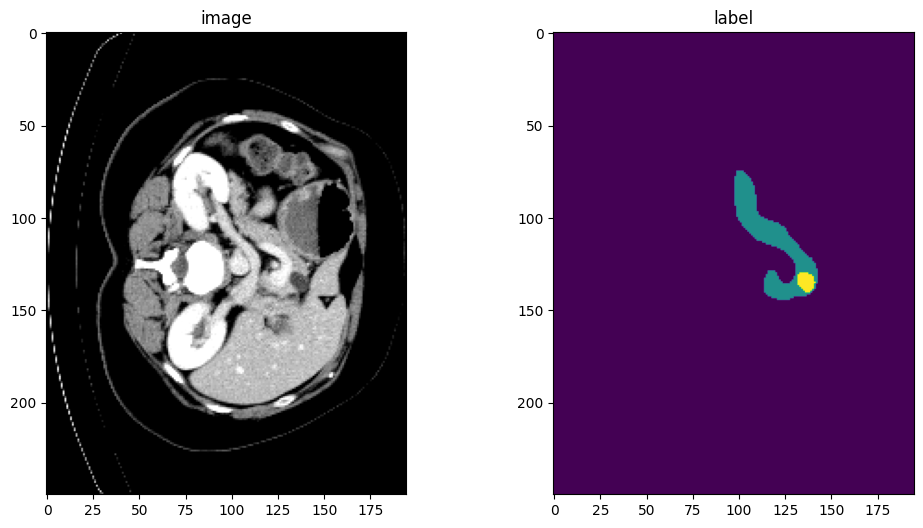

In [21]:
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.utils import first, set_determinism

check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, target_layer], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, target_layer])
plt.show()

In [22]:
from monai.data import CacheDataset, DataLoader

train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4, progress=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4, progress=True)

Loading dataset: 100%|██████████████████████████| 20/20 [00:33<00:00,  1.68s/it]


In [23]:
def convert_label_2ch(dataset):
    for data in dataset:
        data['label'][0] = torch.where(data['label'][0].byte(), 1., 0.)
        
convert_label_2ch(train_ds[0])
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=10)

convert_label_2ch(val_ds)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=10)

In [24]:
from monai.networks.nets import AttentionUnet


device = torch.device("cuda:0")
out_channels = 3
model = AttentionUnet(
    spatial_dims=3,
    in_channels=1,
    out_channels=out_channels,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2)
).to(device)

In [25]:
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [26]:
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

In [27]:
from monai.data.utils import decollate_batch
from monai.transforms import EnsureType, AsDiscrete
from monai.inferers import sliding_window_inference

max_epochs = 20
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=out_channels)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=out_channels)])
model_name = 'pancreas_UNet2'

In [28]:
%%time 

import time 

for epoch in range(max_epochs):
    tic_epoch = time.time()
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if step % 5 ==0:
            print(
                f"\nepoch {epoch + 1}/{max_epochs}"
                f" steps {step}/{len(train_ds) // train_loader.batch_size}, "
                f"|train_loss: {loss.item():.4f}", end='')
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    toc_epoch = time.time()
    dur_epoch = toc_epoch - tic_epoch
    print(f" |avg loss: {epoch_loss:.4f} dur {dur_epoch:.1f}s ", end='')

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 2
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            #print( "| Val Dice metric {:6.4f}".format(metric) , end='')
            # reset the status for next validation round
            dice_metric.reset()

            
            metric_values.append(metric)
            print(
                f"|DICE cur: {metric:.4f}"
                f" old best : {best_metric:.4f} "
                f"at {best_metric_epoch}" , end=''            )
            
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "{}_model_best.pth".format(model_name)))
                torch.save(optimizer.state_dict(), os.path.join(root_dir, "{}_optim_best.pth".format(model_name)))
                print("|best model saved", end='')            

    if (epoch+1) % 10 == 0: 
        torch.save(model.state_dict(), os.path.join(root_dir, "{}_model_{:04d}.pth".format(model_name, epoch+1)))
        torch.save(optimizer.state_dict(), os.path.join(root_dir, "{}_optim_{:04d}.pth".format(model_name, epoch+1)))
        print("|{}ep model saved".format(epoch+1), end='')
                            
print(
    f"\ntrain completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}"
    f" for {max_epochs} epoches" )


epoch 1/20 steps 5/80, |train_loss: 0.7491
epoch 1/20 steps 10/80, |train_loss: 0.7177
epoch 1/20 steps 15/80, |train_loss: 0.7441
epoch 1/20 steps 20/80, |train_loss: 0.7182
epoch 1/20 steps 25/80, |train_loss: 0.7196
epoch 1/20 steps 30/80, |train_loss: 0.7065
epoch 1/20 steps 35/80, |train_loss: 0.6562
epoch 1/20 steps 40/80, |train_loss: 0.7016
epoch 1/20 steps 45/80, |train_loss: 0.7120
epoch 1/20 steps 50/80, |train_loss: 0.7381
epoch 1/20 steps 55/80, |train_loss: 0.7504
epoch 1/20 steps 60/80, |train_loss: 0.7300
epoch 1/20 steps 65/80, |train_loss: 0.6958
epoch 1/20 steps 70/80, |train_loss: 0.7041
epoch 1/20 steps 75/80, |train_loss: 0.7287
epoch 1/20 steps 80/80, |train_loss: 0.6683 |avg loss: 0.7200 dur 820.4s 
epoch 2/20 steps 5/80, |train_loss: 0.6458
epoch 2/20 steps 10/80, |train_loss: 0.6546
epoch 2/20 steps 15/80, |train_loss: 0.7264
epoch 2/20 steps 20/80, |train_loss: 0.7407
epoch 2/20 steps 25/80, |train_loss: 0.7348
epoch 2/20 steps 30/80, |train_loss: 0.6356
epo

In [29]:
!rm -rf pymp-*

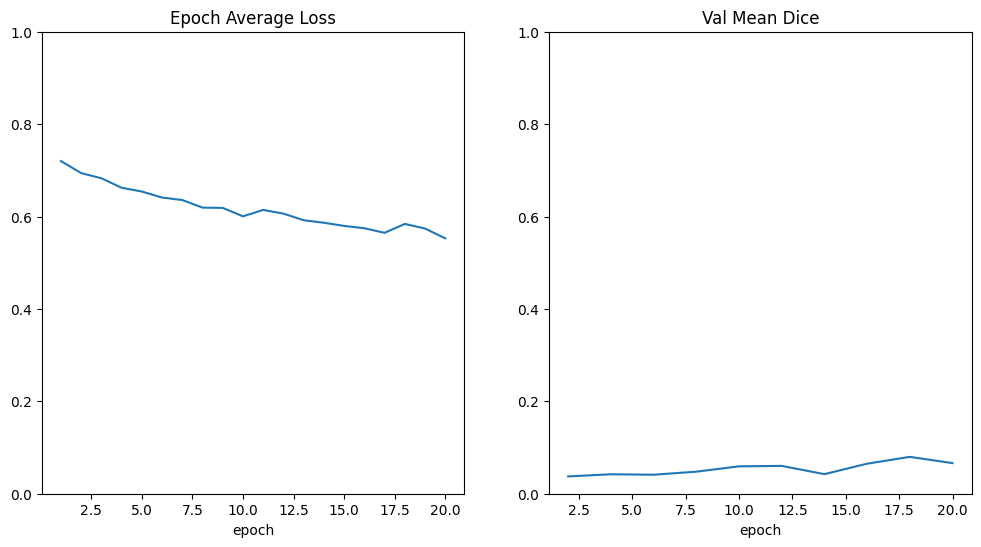

In [30]:
import matplotlib.pyplot as plt

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.ylim(0,1)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.ylim(0,1)
plt.show()

In [31]:
def inference_segment(model, roi_size, sw_batch_size, num_data=2):
    with torch.no_grad():
        for i, val_data in enumerate(val_loader):
            roi_size = (160, 160, 160)
            sw_batch_size = 4
            val_outputs = sliding_window_inference(
                val_data["image"].to(device), roi_size, sw_batch_size, model
            )
            # plot the slice [:, :, target_layer]
            plt.figure("check", (18, 6))
            plt.subplot(1, 3, 1)
            plt.title(f"image {i}")
            plt.imshow(val_data["image"][0, 0, :, :, target_layer], cmap="gray")
            plt.subplot(1, 3, 2)
            plt.title(f"label {i}")
            plt.imshow(val_data["label"][0, 0, :, :, target_layer])
            plt.subplot(1, 3, 3)
            plt.title(f"output {i}")
            plt.imshow(torch.argmax(
                val_outputs, dim=1).detach().cpu()[0, :, :, target_layer])
            plt.show()
            if i == num_data:
                break                
    
def inference_segment_best(work_dir, model, roi_size, sw_batch_size, num_data=2):
    import torch
    model.load_state_dict(torch.load(os.path.join(work_dir, "{}_model_best.pth".format(model_name))))
    model.eval()
    inference_segment(model, roi_size, sw_batch_size, num_data)

def inference_segment_epoch(work_dir, model, roi_size, sw_batch_size, epoch=30, num_data=2):
    import torch
    model.load_state_dict(torch.load(os.path.join(work_dir, "{}_model_{:04d}.pth".format(model_name, epoch))))
    model.eval()
    inference_segment(model, roi_size, sw_batch_size, num_data)

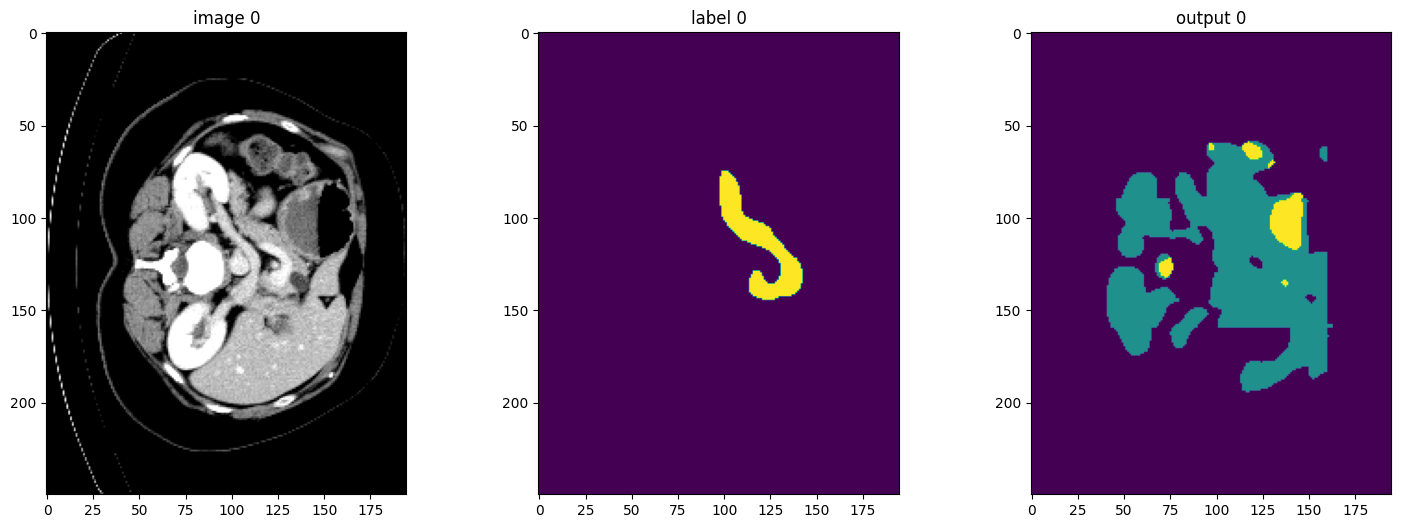

In [32]:
roi_size = (160, 160, 160)
sw_batch_size = 4
inference_segment_best(root_dir, model, roi_size, sw_batch_size, num_data=0)

In [33]:
!ls -alh temp/*.pth

-rw-rw-r-- 1 aistore3 aistore3  91M Mar  3 13:09 temp/pancreas_UNet2_model_0010.pth
-rw-rw-r-- 1 aistore3 aistore3  91M Mar  3 15:37 temp/pancreas_UNet2_model_0020.pth
-rw-rw-r-- 1 aistore3 aistore3  74M Mar  3 04:15 temp/pancreas_UNet2_model_0030.pth
-rw-rw-r-- 1 aistore3 aistore3  74M Mar  3 05:04 temp/pancreas_UNet2_model_0040.pth
-rw-rw-r-- 1 aistore3 aistore3  74M Mar  3 05:52 temp/pancreas_UNet2_model_0050.pth
-rw-rw-r-- 1 aistore3 aistore3  74M Mar  3 06:40 temp/pancreas_UNet2_model_0060.pth
-rw-rw-r-- 1 aistore3 aistore3  74M Mar  3 07:28 temp/pancreas_UNet2_model_0070.pth
-rw-rw-r-- 1 aistore3 aistore3  74M Mar  3 08:17 temp/pancreas_UNet2_model_0080.pth
-rw-rw-r-- 1 aistore3 aistore3  74M Mar  3 09:04 temp/pancreas_UNet2_model_0090.pth
-rw-rw-r-- 1 aistore3 aistore3  74M Mar  3 09:52 temp/pancreas_UNet2_model_0100.pth
-rw-rw-r-- 1 aistore3 aistore3  91M Mar  3 15:08 temp/pancreas_UNet2_model_best.pth
-rw-rw-r-- 1 aistore3 aistore3 181M Mar  3 13:09 temp/pancreas_UNet2_optim_0

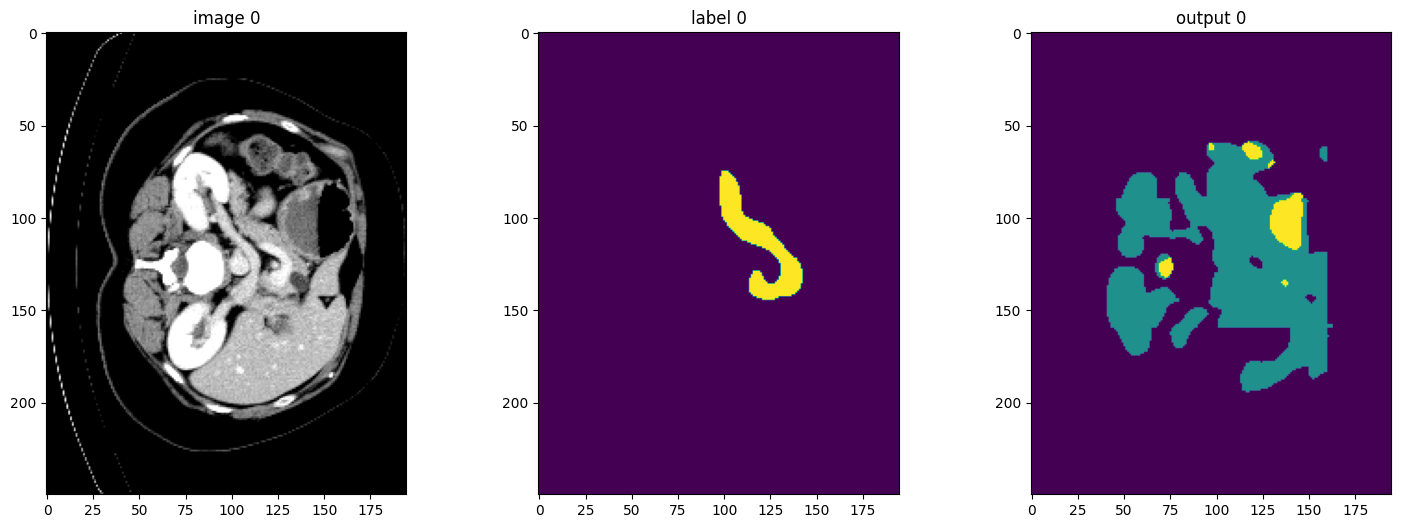

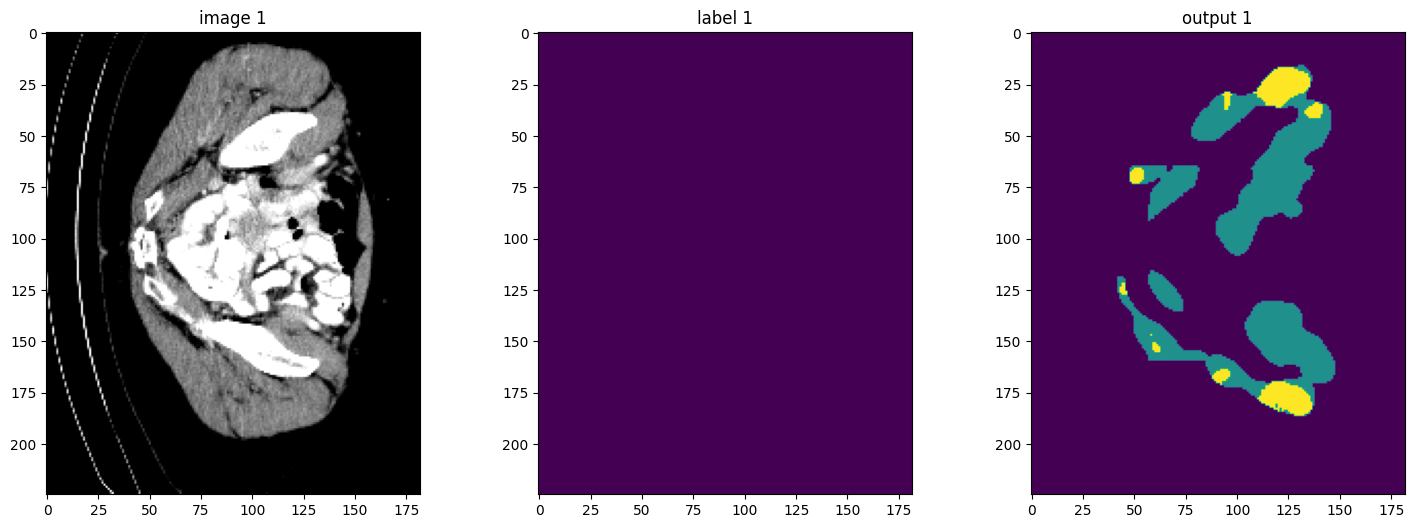

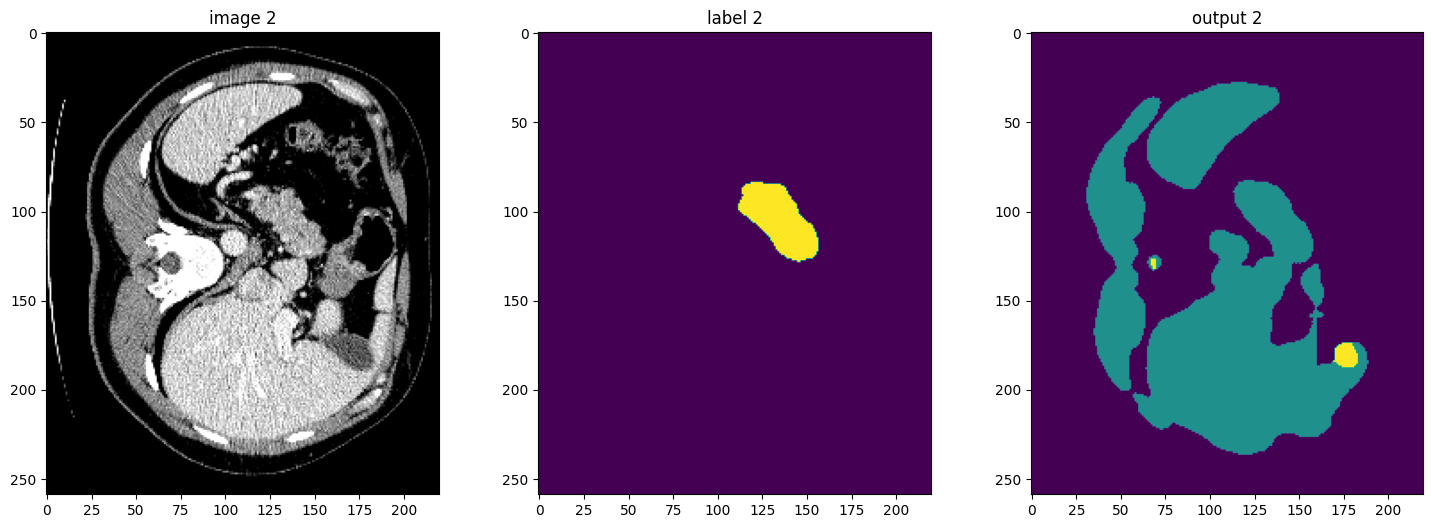

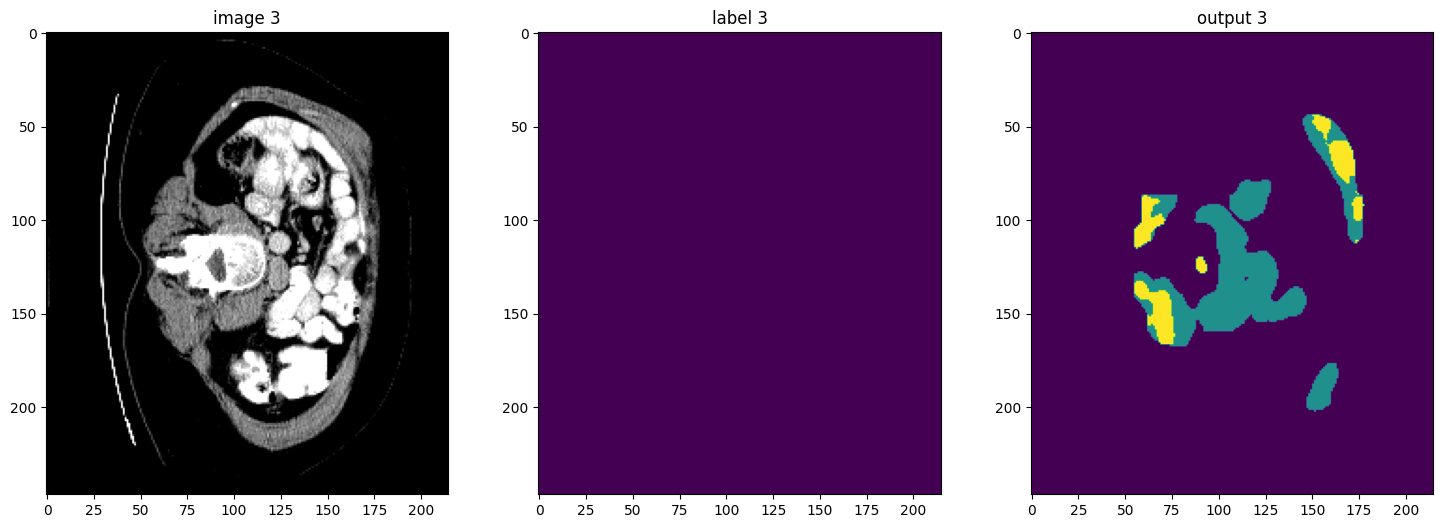

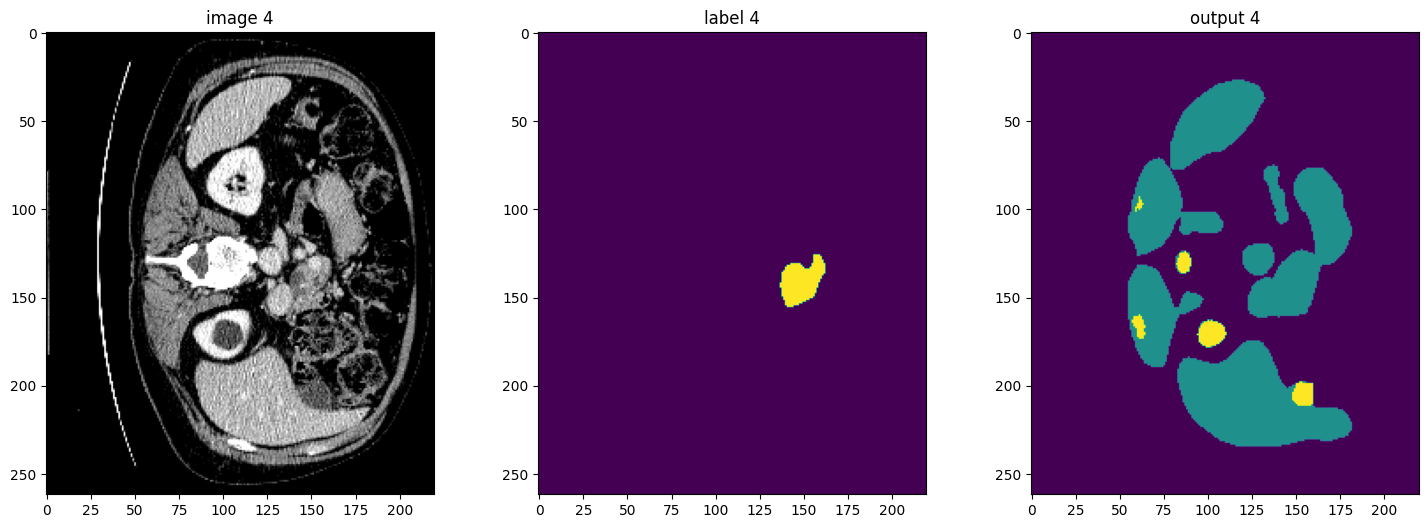

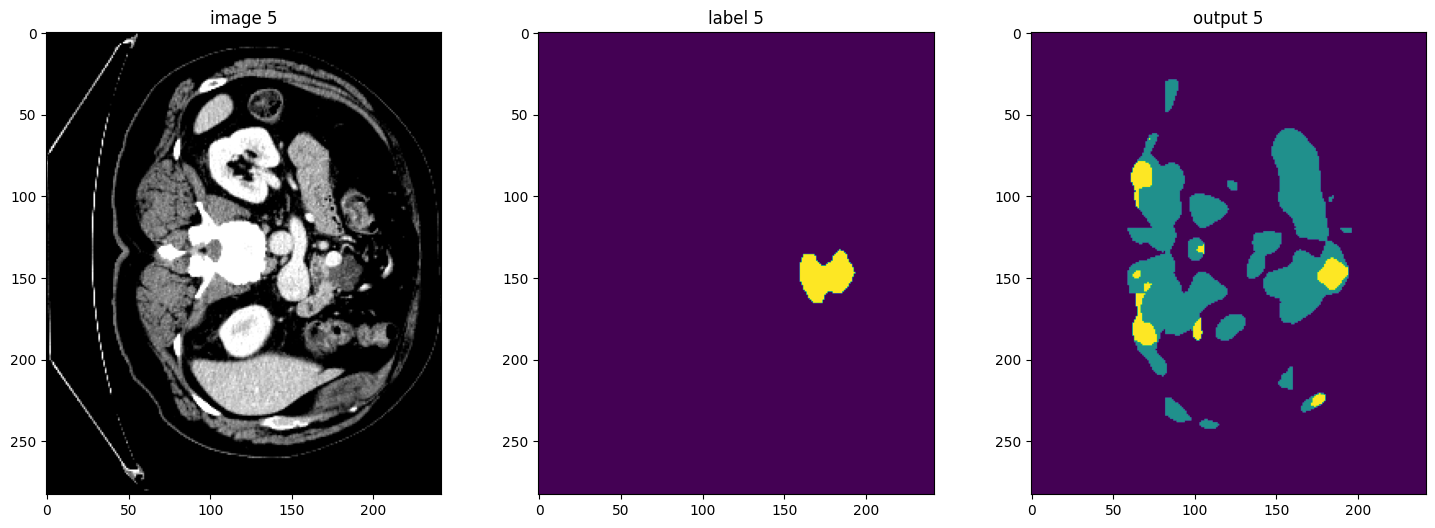

In [34]:
inference_segment_best(root_dir, model, roi_size, sw_batch_size, num_data=5)